In [2]:
# Import packages
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
# Read csv file
# Source: https://archive.ics.uci.edu/ml/datasets/HTRU2
htru_data <- read_csv('https://raw.githubusercontent.com/iaujla01/DSCI100Project/main/data/HTRU_2.csv', col_names = FALSE)

# Adding column names: 
# 1. Mean of the integrated profile
# 2. Standard deviation of the integrated profile
# 3. Excess kurtosis of the integrated profile 
# 4. Skewness of the integrated profile
# 5. Mean of the DM-SNR curve
# 6. Standard deviation of the DM-SNR curve
# 7. Excess kurtosis of the DM-SNR curve
# 8. Skewness of the DM-SNR curve
# 9. Class
colnames(htru_data) <- c('mean_ip', 'sd_ip', 'kurtosis_ip', 'skew_ip', 'mean_dmsnr', 'sd_dmsnr', 'kurtosis_dmsnr', 'skew_dmsnr', 'class')
htru_data <- htru_data %>% 
    mutate(class = as.factor(class)) # since class is a dummy variable that is either positive (1) or negative (0)
head(htru_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double()
)



mean_ip,sd_ip,kurtosis_ip,skew_ip,mean_dmsnr,sd_dmsnr,kurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [4]:
# 17,898 total examples; 1,639 positive examples; 16,259 negative examples
# Decide to split dataset into 75% training and 25% testing

htru_split <- initial_split(htru_data, prop = 0.75, strata = class)
htru_train <- training(htru_split)
htru_test <- testing(htru_split)

glimpse(htru_train)
glimpse(htru_test)

Rows: 13,424
Columns: 9
$ mean_ip        <dbl> 102.50781, 88.72656, 93.57031, 119.48438, 107.25000, 1…
$ sd_ip          <dbl> 58.88243, 40.67223, 46.69811, 48.76506, 52.62708, 45.2…
$ kurtosis_ip    <dbl> 0.465318154, 0.600866079, 0.531904850, 0.031460220, 0.…
$ skew_ip        <dbl> -0.51508791, 1.12349169, 0.41672112, -0.11216757, 0.17…
$ mean_dmsnr     <dbl> 1.6772575, 1.1789298, 1.6362876, 0.9991639, 2.3319398,…
$ sd_dmsnr       <dbl> 14.860146, 11.468720, 14.545074, 9.279612, 14.486853, …
$ kurtosis_dmsnr <dbl> 10.576487, 14.269573, 10.621748, 19.206230, 9.001004, …
$ skew_dmsnr     <dbl> 127.39358, 252.56731, 131.39400, 479.75657, 107.97251,…
$ class          <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, …
Rows: 4,474
Columns: 9
$ mean_ip        <dbl> 140.56250, 103.01562, 136.75000, 130.38281, 107.25781,…
$ sd_ip          <dbl> 55.68378, 39.34165, 57.17845, 39.84406, 39.49649, 45.5…
$ kurtosis_ip    <dbl> -0.23457141, 0.32332837, -0.06841464, -0.15832276, 0.4…
$ ske

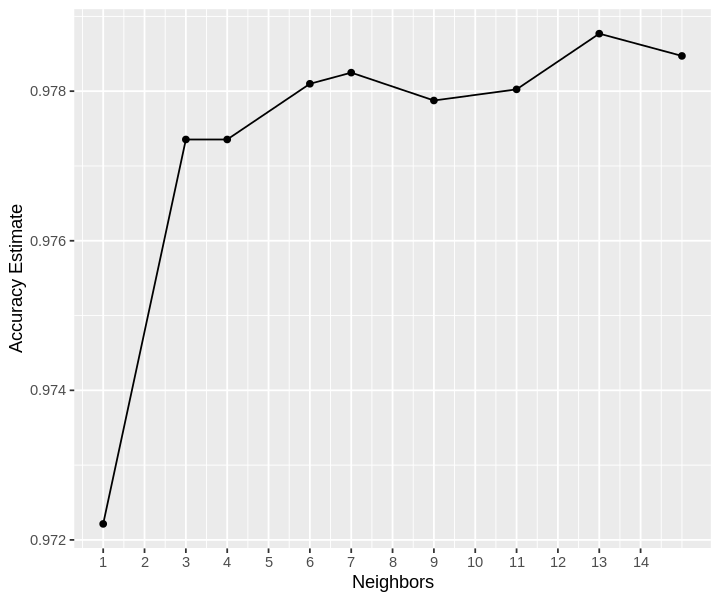

In [5]:
options(repr.plot.height = 5, repr.plot.width = 6)

htru_tune <- nearest_neighbor(weight_func = "rectangular", 
                              neighbors = tune()) %>%
             set_engine("kknn") %>%
             set_mode("classification")

htru_recipe <- recipe(class ~. , data = htru_train)%>%
               step_scale(all_predictors()) %>%
               step_center(all_predictors())

htru_vfold <- vfold_cv(htru_train, v = 5, strata = class)

htru_results <- workflow() %>%
       add_recipe(htru_recipe) %>%
       add_model(htru_tune) %>%
       tune_grid(resamples = htru_vfold, grid = 10) %>%
       collect_metrics()

accuracies <- htru_results %>% 
       filter(.metric == "accuracy")

cross_val_plot  <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1))

cross_val_plot 